# **COMPUTER VISISON**


* `torchvision.datasets` - get dataset and data laoding functions for cv
* `torchvision.models` - get pretrained cv models 
* `torchvivion.transforms` - functions for manipulating vision
* `torch.utils.data.Dataset` - base dataset class for pytorch
* `torch.utls.data.DataLoader` - cretes python iterable over a dataset

In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import helper_function as func

print(torch.__version__)
print(torchvision.__version__)

2.5.0+cu121
0.20.0+cu121


## **Dataset**

**FashionMNIST**


In [3]:
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

In [11]:
len(train), len(test)

(60000, 10000)

In [12]:
class_names = train.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
class_to_rdx = train.class_to_idx
class_to_rdx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image shape: torch.Size([1, 28, 28]) 
Label: 9


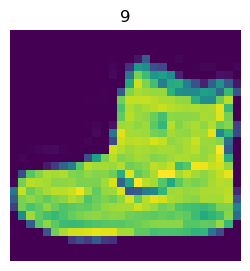

In [14]:
image, label = train[0]
print(f"Image shape: {image.shape} \nLabel: {label}")
plt.figure(figsize=(3,3))
plt.imshow(image[-1])
plt.title(label)
plt.axis(False);

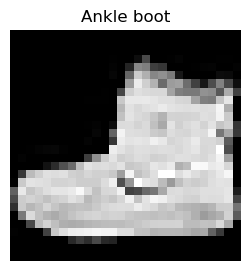

In [15]:
plt.figure(figsize=(3,3))
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False);

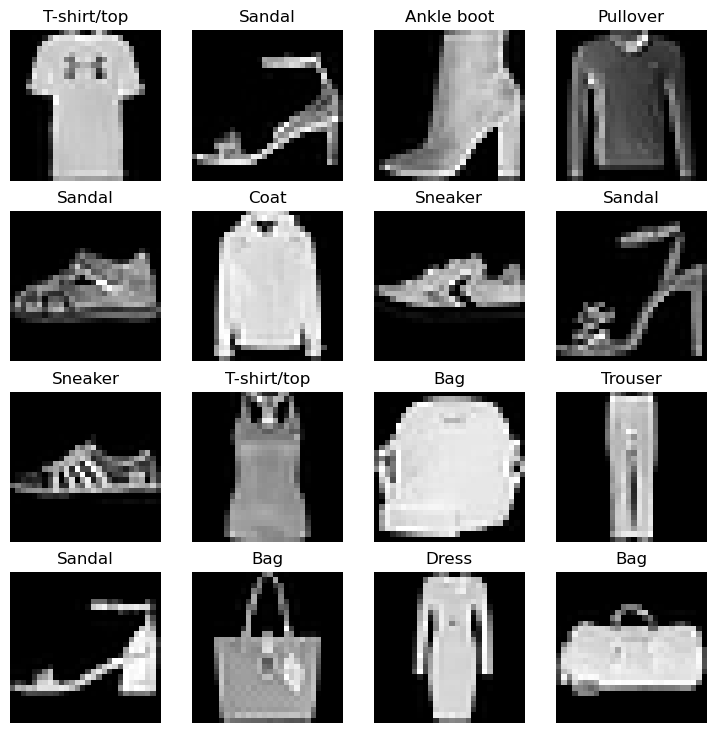

In [16]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train),size=[1]).item()
    img,label = train[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)
    

## **PREPARE DATALOADER**

In [19]:
BATCH_SIZE = 32
trainDataLoader = DataLoader(dataset=train,batch_size=BATCH_SIZE,shuffle=True)
testDataLoader = DataLoader(dataset=test,batch_size=BATCH_SIZE, shuffle=True)
trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x2992b7cd650>,
 <torch.utils.data.dataloader.DataLoader at 0x2992c783d10>)

In [21]:
print(f"Length of Train Data Loader is {len(trainDataLoader)} of batches {BATCH_SIZE}")
print(f"Length of Test Data Loader is {len(testDataLoader)} of batches {BATCH_SIZE}")

Length of Train Data Loader is 1875 of batches 32
Length of Test Data Loader is 313 of batches 32


In [22]:
trainfeaturesbatch, trainlabelsbatch = next(iter(trainDataLoader))
trainfeaturesbatch.shape, trainlabelsbatch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## **BASELINE MODEL**

### **Creating baseline model**

In [24]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.Linear(in_features=hidden_unit, out_features=output_shape)
        )
        
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer_stack(x)

In [36]:
baseline_model = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_unit=10,
    output_shape=len(class_names)
).to("cpu")
baseline_model

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### **Setting up loss and optimzier**

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr = 0.1) 

In [38]:
from timeit import default_timer as timer

In [39]:
def total_time(start: float, end: float, device: torch.device = None) -> float:
    total_time = end - start
    return f"Total time taken is {total_time} seconds "

In [40]:
start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n----')
    trainloss = 0
    # $add a loop to loop through the training batches
    for batch, (x,y) in enumerate (trainDataLoader):
        baseline_model.train()
        trainpred = baseline_model(x)
        loss = loss_fn(trainpred,y)
        trainloss += loss

        optimizer.zero_grad()

        loss.backward()

        if batch % 400 == 0:
            print(f'Looked at {batch*len(x)}/{len(trainDataLoader.dataset)}')

    trainloss /= len(trainDataLoader)
    
    testloss, testacc = 0,0
    baseline_model.eval()
    with torch.inference_mode():
        for xtest,ytest in testDataLoader:
            testpred = baseline_model(xtest)
            testloss += loss_fn(testpred, ytest)
            testacc += func.accuracy_fn(y_true=ytest, y_pred=testpred.argmax(dim=1))
        testloss /= len(testDataLoader)
        testacc /= len(testDataLoader)
        
    print(f"\nTrain Loss: {trainloss:} | Test Loss: {testloss:} | Test Accuracy: {testacc:} ")
    
end = timer()
baseline_time = total_time(start, end,device=str(next(baseline_model.parameters()).device))
baseline_time

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.299964427947998 | Test Loss: 2.3005406856536865 | Test Accuracy: 9.564696485623003 
Epoch: 1
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.2999634742736816 | Test Loss: 2.300574779510498 | Test Accuracy: 9.544728434504792 
Epoch: 2
----
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 2.2999632358551025 | Test Loss: 2.3005080223083496 | Test Accuracy: 9.564696485623003 


'Total time taken is 34.92288389999885 seconds '

In [50]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            ypred = model(x)
            loss += loss_fn(ypred,y)
            acc += accuracy_fn(y, ypred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc,
    }

In [51]:
baseline_model_results = eval_model(model=baseline_model,data_loader=testDataLoader,loss_fn=loss_fn,accuracy_fn=func.accuracy_fn)
baseline_model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 2.3004515171051025,
 'model_acc': 9.554712460063898}

## **IMPROVING THE PERFORMANCE**

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### **Creating new model architecture**

In [59]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit, out_features=output_shape),
            nn.ReLU(),
            
        )
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.layer_stack(x)
    

In [60]:
torch.manual_seed(42)
model1 = FashionMNISTModelV1(input_shape=784, hidden_unit=10, output_shape=len(class_names)).to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### **Setting up loss function and optimizser**